<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/imagenette_mobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l
!pip install --upgrade torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
  Attempting uninstall: scipy
    Foun

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

- Measure performance of LeNet and alexNet on the imagenette dataset

In [1]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

import torchvision
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import os
from matplotlib import pyplot as plt


device_type = 'cpu'
if torch.cuda.is_available():
  device_type = 'cuda'

device = torch.device(device_type)
device

device(type='cuda')

In [2]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, pooling=False, activation=nn.ReLU, groups=1, padding=1, kernel_size=3, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, groups=groups, stride=stride),
            nn.BatchNorm2d(out_channels),
            activation()
        )
        if pooling:
            self.net.add_module("pooling", nn.MaxPool2d(2))

    def forward(self, x):
      return self.net(x)

class ResidualAdd(nn.Module):
    def __init__(self, block, short_cut=None):
        super().__init__()
        self.block = block
        self.short_cut = short_cut

    def forward(self, x):
      res = self.block(x)
      if self.short_cut:
        x = self.short_cut(x)
      return x + res

class MBConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, bottleneck_factor=4, stride=1):
        super().__init__()
        self.bottleneck_channels = int(out_channels * bottleneck_factor)
        self.block = nn.Sequential(
            ConvBlock(in_channels, self.bottleneck_channels, kernel_size=1, padding=0, stride=stride),
            ConvBlock(self.bottleneck_channels, self.bottleneck_channels, kernel_size=3, padding=1, groups=self.bottleneck_channels, stride=1),
            ConvBlock(self.bottleneck_channels, out_channels, kernel_size=1, activation=nn.Identity, padding=0, stride=1),
        )
        self.net = ResidualAdd(self.block, short_cut=ConvBlock(in_channels, out_channels, kernel_size=1, padding=0, stride=stride))

    def forward(self, x):
      return self.net(x)

## Convert pytorch data loader into d2l data module

In [8]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class MobileNetV2(d2l.Classifier):
    """
    """
    def __init__(self, num_classes=10, width_multiplier=1, lr=0.1):
        super().__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.width_multiplier = width_multiplier
        self.net = nn.Sequential(
            ConvBlock(3, 32, kernel_size=3, padding=1, stride=2),

            #B1
            MBConvBlock(32, out_channels=16, stride=1),

            #B2
            MBConvBlock(16, out_channels=24, stride=2, bottleneck_factor=6),
            MBConvBlock(24, out_channels=24, stride=1, bottleneck_factor=6),

            #B3
            MBConvBlock(24, out_channels=32, stride=2, bottleneck_factor=6),
            MBConvBlock(32, out_channels=32, stride=1, bottleneck_factor=6),
            MBConvBlock(32, out_channels=32, stride=1, bottleneck_factor=6),

            #B4
            MBConvBlock(32, out_channels=64, stride=2, bottleneck_factor=6),
            MBConvBlock(64, out_channels=64, stride=1, bottleneck_factor=6),
            MBConvBlock(64, out_channels=64, stride=1, bottleneck_factor=6),
            MBConvBlock(64, out_channels=64, stride=1, bottleneck_factor=6),

            #B5
            MBConvBlock(64, out_channels=96, stride=1, bottleneck_factor=6),
            MBConvBlock(96, out_channels=96, stride=1, bottleneck_factor=6),
            MBConvBlock(96, out_channels=96, stride=1, bottleneck_factor=6),

            #B6
            MBConvBlock(96, out_channels=160, stride=2, bottleneck_factor=6),
            MBConvBlock(160, out_channels=160, stride=1, bottleneck_factor=6),
            MBConvBlock(160, out_channels=160, stride=1, bottleneck_factor=6),

            #B7
            MBConvBlock(160, out_channels=320, stride=1, bottleneck_factor=6),

            #Conv2d
            ConvBlock(320, out_channels=1280, kernel_size=1, padding=0, stride=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(1280, num_classes, kernel_size=1),
            nn.Flatten()
        )

    def forward(self, x):
      return self.net(x)

    def layer_summary(self, X_shape):
      X = torch.randn(*X_shape)
      total_params = 0
      for layer in self.net:
        X = layer(X)
        params = sum([p.numel() for p in layer.parameters()])
        print(layer.__class__.__name__, "output shape = ", X.shape, "Mparams = ", params/1e6)
        total_params += params
      print("Total params In M = ", total_params / (1e6))


mobile_model = MobileNetV2()
mobile_model.layer_summary((1, 3, 224, 224))

ConvBlock output shape =  torch.Size([1, 32, 112, 112]) Mparams =  0.00096
MBConvBlock output shape =  torch.Size([1, 16, 112, 112]) Mparams =  0.00464
MBConvBlock output shape =  torch.Size([1, 24, 56, 56]) Mparams =  0.008448
MBConvBlock output shape =  torch.Size([1, 24, 56, 56]) Mparams =  0.009792
MBConvBlock output shape =  torch.Size([1, 32, 28, 28]) Mparams =  0.014592
MBConvBlock output shape =  torch.Size([1, 32, 28, 28]) Mparams =  0.016384
MBConvBlock output shape =  torch.Size([1, 32, 28, 28]) Mparams =  0.016384
MBConvBlock output shape =  torch.Size([1, 64, 14, 14]) Mparams =  0.045056
MBConvBlock output shape =  torch.Size([1, 64, 14, 14]) Mparams =  0.059392
MBConvBlock output shape =  torch.Size([1, 64, 14, 14]) Mparams =  0.059392
MBConvBlock output shape =  torch.Size([1, 64, 14, 14]) Mparams =  0.059392
MBConvBlock output shape =  torch.Size([1, 96, 14, 14]) Mparams =  0.10752
MBConvBlock output shape =  torch.Size([1, 96, 14, 14]) Mparams =  0.129024
MBConvBlock o

In [4]:
class ImageNette(d2l.DataModule):
    """ImageNette d2l module.

    Defined in :numref:`sec_fashion_mnist`"""
    def __init__(self, batch_size=128, resize=(224, 224), download=True):
        super().__init__()
        self.train_root = "../train_data/"
        self.val_root = "../val_data/"
        self.save_hyperparameters()
        transform= transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(resize),
        transforms.ToTensor()])
        self.train = datasets.Imagenette(root=self.train_root, split='train', download=download, transform=transform)
        self.val = datasets.Imagenette(root=self.val_root, split='val', download=download, transform=transform)
        self.labels = self.train.classes

    def text_labels(self, indices):
        """Return text labels.

        Defined in :numref:`sec_fashion_mnist`"""
        return [self.labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        """Defined in :numref:`sec_fashion_mnist`"""
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=self.num_workers)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        """Defined in :numref:`sec_fashion_mnist`"""
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

In [43]:
!rm -rf ../train_data/imagenette2/
!rm -rf ../val_data/imagenette2/

In [5]:
data = ImageNette(batch_size=128, download=False)
testing_data = ImageNette(batch_size=40, download=False)
data

In [6]:

def get_loss(model, data):
  model.train = False

  losses, access = [], []
  for (inputs, outputs) in data.val_dataloader():
    preds = model.forward(inputs.to(device))
    loss = model.loss(preds, outputs.to(device)).item()
    acc = model.accuracy(preds, outputs.to(device)).item()
    losses.append(loss)
    access.append(acc)

  return np.mean(np.array(losses)), np.mean(np.array(access))

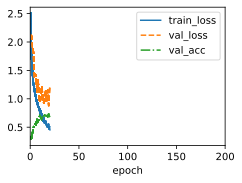

In [ ]:
trainer = d2l.Trainer(max_epochs=200, num_gpus=1)
mobile_net = MobileNetV2(lr=0.1)
mobile_net.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(mobile_net, data)
get_loss(mobile_net, testing_data)

In [ ]:
from google.colab import files
import helper

torch.save(mobile_net.state_dict(), 'mobile_net.pth')
files.download('mobile_net.pth')

In [ ]:
!nvidia-smi

Wed Mar 13 22:10:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              39W / 300W |  13952MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--